<a href="https://colab.research.google.com/github/mmadyda/OpenCV/blob/master/dron_samolot_helikopter_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import bibliotek



In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
np.set_printoptions(precision=6, suppress=True)

##Załadowanie danych

In [0]:
 !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
 !unzip -q flying-vehicles.zip

--2020-05-07 14:30:08--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   242MB/s    in 6.8s    

2020-05-07 14:30:15 (217 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



##Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [0]:
!rm -rf ./images

In [0]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone','fighter-jet','helicopter','missile','passenger-plane','rocket']
for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [0]:
data_dir='./images'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')     # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')     # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir,'test')        # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir,'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')
train_helicopter_dir = os.path.join(train_dir, 'helicopter')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')
valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')
test_helicopter_dir = os.path.join(test_dir, 'helicopter')

for directory in (train_dir, valid_dir, test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, train_helicopter_dir,
        valid_drone_dir, valid_passenger_dir, valid_helicopter_dir,
        test_drone_dir, test_passenger_dir, test_helicopter_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)

    

In [0]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))
helicopter_fnames = os.listdir(os.path.join(base_dir, 'helicopter'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]
helicopter_fnames = [fname for fname in helicopter_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]

In [0]:
size = min(len(drone_fnames),len(passenger_fnames), len(helicopter_fnames))

train_size = int(np.floor(0.7*size))
valid_size = int(np.floor(0.2*size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [0]:
for i, fname in enumerate(drone_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(train_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i <= valid_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(valid_drone_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'drone', fname)
    dst = os.path.join(test_drone_dir, fname)
    shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(train_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i <= valid_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(valid_passenger_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'passenger-plane', fname)
    dst = os.path.join(test_passenger_dir, fname)
    shutil.copyfile(src, dst)

for i, fname in enumerate(helicopter_fnames):
  if i <= train_idx:
    src = os.path.join(base_dir, 'helicopter', fname)
    dst = os.path.join(train_helicopter_dir, fname)
    shutil.copyfile(src, dst)
  elif train_idx < i <= valid_idx:
    src = os.path.join(base_dir, 'helicopter', fname)
    dst = os.path.join(valid_helicopter_dir, fname)
    shutil.copyfile(src, dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir, 'helicopter', fname)
    dst = os.path.join(test_helicopter_dir, fname)
    shutil.copyfile(src, dst)


In [0]:
print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

print('helicopter - zbiór treningowy', len(os.listdir(train_helicopter_dir)))
print('helicopter - zbiór walidacyjny', len(os.listdir(valid_helicopter_dir)))
print('helicopter - zbiór testowy', len(os.listdir(test_helicopter_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131
helicopter - zbiór treningowy 919
helicopter - zbiór walidacyjny 262
helicopter - zbiór testowy 131


##Eksploracja danych

(-0.5, 1049.5, 699.5, -0.5)

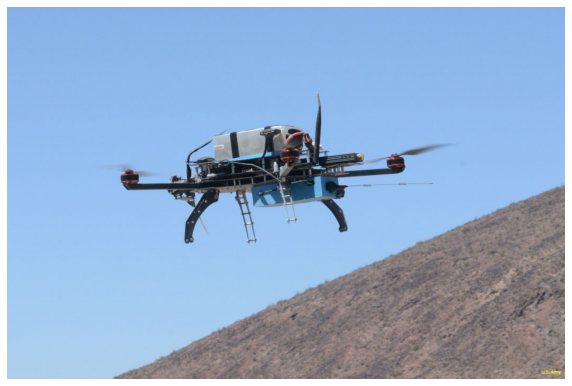

In [0]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego
idx = 220 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 2775.5, 1855.5, -0.5)

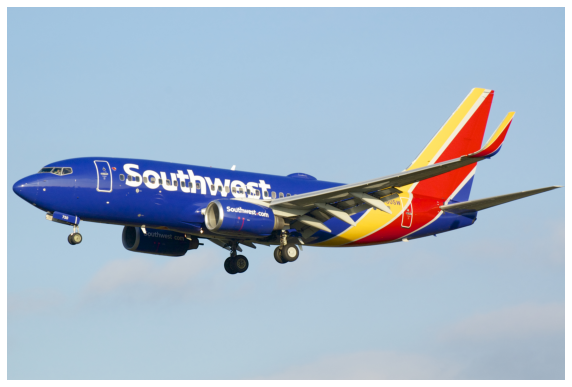

In [0]:
#@title Wybierz indeks przykładowego zdjęcia samolotu ze zbioru treningowego
idx = 128 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 2199.5, 1079.5, -0.5)

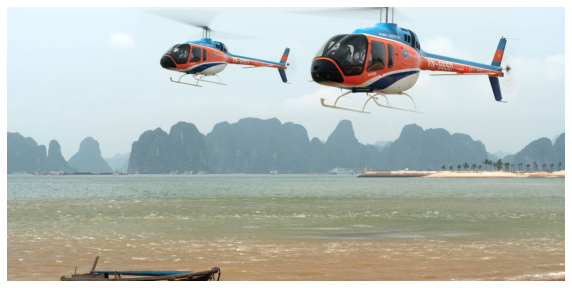

In [0]:
#@title Wybierz indeks przykładowego zdjęcia samolotu ze zbioru treningowego
idx = 128 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(helicopter_fnames))
img_path = os.path.join(train_helicopter_dir, names_mapping[idx])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

##Argumentacja danych

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1.0/255.0,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(directory = valid_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')


Found 2757 images belonging to 3 classes.
Found 786 images belonging to 3 classes.


##Wyświetlanie efektu argumentacji danych

In [0]:
def display_augumented_images(directory, idx):
  '''
  Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki argumentacji danych
  '''

  fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
  img_path = fnames[idx]
  img = image.load_img(img_path, target_size=(150, 150))

  x = image.img_to_array(img)
  x = x.reshape((1, ) + x.shape)

  i = 1
  plt.figure(figsize=(16, 8))
  for batch in train_datagen.flow(x,batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:he first found
      String addr = deviceList[0].IpAddress;
      GigEHandle hDev = GigEVision_OpenDevice(addr);
      GigEVision_StartAcquisition(hDev, "Mono8");

      // Main loop
      Image image1, image2;
      for (int i = 0; i < 100; ++i)
      {
         // Grab image
         GigEVision_ReceiveImage(hDev, image1);

         // Process image
         ThresholdImage(image1, NIL, 128.0f, NIL, 0.0f, image2);

         // Save to file
         char fileName[16];
         sprintf(fileName, "%05d.png", i);
         SaveImage(image2, ImageFileFormat::PNG, fileName, false);
      }
      break


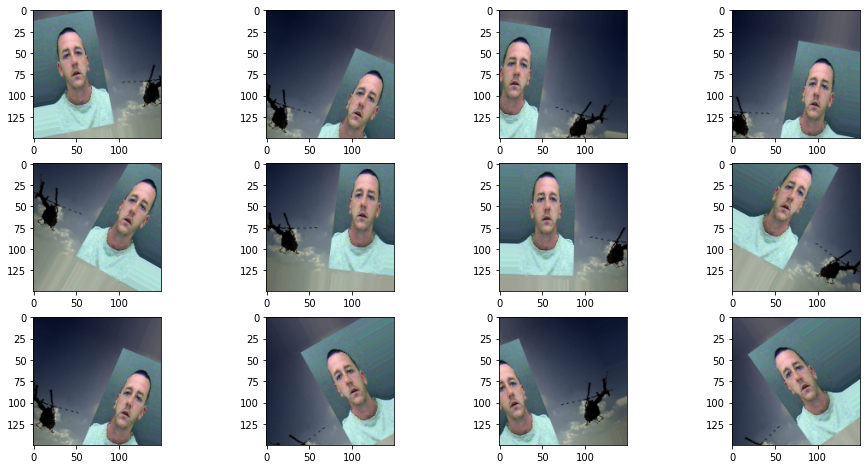

In [0]:
#@title Zbiór treningowy drone:
idx = 675 #@param {type: 'slider', min:0, max:919}
typ = train_helicopter_dir #@param ["train_drone_dir", "train_passenger_dir","train_helicopter_dir"]{type:"raw"}

display_augumented_images(typ, idx)

##Budowa modelu

In [0]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

##Transfer learning z modelu VGG19 - odmrożenie kilku ostatnich warstw

In [0]:
conv_base = VGG19(weights = 'imagenet', include_top = False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
  for layer in model.layers:
    print(f'layer name: {layer.name} trainable: {layer.trainable}')

print_layers(conv_base)

80142336/80134624 [==============================] - 1s 0us/step
layer name: input_1 trainable: True
layer name: block1_conv1 trainable: True
layer name: block1_conv2 trainable: True
layer name: block1_pool trainable: True
layer name: block2_conv1 trainable: True
layer name: block2_conv2 trainable: True
layer name: block2_pool trainable: True
layer name: block3_conv1 trainable: True
layer name: block3_conv2 trainable: True
layer name: block3_conv3 trainable: True
layer name: block3_conv4 trainable: True
layer name: block3_pool trainable: True
layer name: block4_conv1 trainable: True
layer name: block4_conv2 trainable: True
layer name: block4_conv3 trainable: True
layer name: block4_conv4 trainable: True
layer name: block4_pool trainable: True
layer name: block5_conv1 trainable: True
layer name: block5_conv2 trainable: True
layer name: block5_conv3 trainable: True
layer name: block5_conv4 trainable: True
layer name: block5_pool trainable: True


In [0]:
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  layer.trainable = set_trainable

print_layers(conv_base)

layer name: input_1 trainable: False
layer name: block1_conv1 trainable: False
layer name: block1_conv2 trainable: False
layer name: block1_pool trainable: False
layer name: block2_conv1 trainable: False
layer name: block2_conv2 trainable: False
layer name: block2_pool trainable: False
layer name: block3_conv1 trainable: False
layer name: block3_conv2 trainable: False
layer name: block3_conv3 trainable: False
layer name: block3_conv4 trainable: False
layer name: block3_pool trainable: False
layer name: block4_conv1 trainable: False
layer name: block4_conv2 trainable: False
layer name: block4_conv3 trainable: False
layer name: block4_conv4 trainable: False
layer name: block4_pool trainable: False
layer name: block5_conv1 trainable: True
layer name: block5_conv2 trainable: True
layer name: block5_conv3 trainable: True
layer name: block5_conv4 trainable: True
layer name: block5_pool trainable: True


In [0]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation='relu'))
model.add(layers.Dense(units = 3, activation = 'softmax'))

model.compile(optimizer = optimizers.RMSprop(lr=1e-5),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 22,122,563
Trainable params: 11,537,411
Non-trainable params: 10,585,152
_________________________________________________________________


In [0]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = 30,
                              validation_data=valid_generator,
                              validation_steps = validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
28/28 [==============================] - 22s 779ms/step - loss: 1.0646 - accuracy: 0.4286 - val_loss: 0.9505 - val_accuracy: 0.5430
Epoch 2/30
28/28 [==============================] - 24s 843ms/step - loss: 0.9262 - accuracy: 0.5714 - val_loss: 0.7704 - val_accuracy: 0.6914
Epoch 3/30
28/28 [==============================] - 24s 862ms/step - loss: 0.8258 - accuracy: 0.6417 - val_loss: 0.7775 - val_accuracy: 0.7025
Epoch 4/30
28/28 [==============================] - 24s 847ms/step - loss: 0.7336 - accuracy: 0.6893 - val_loss: 0.5947 - val_accuracy: 0.7578
Epoch 5/30
28/28 [==============================] - 23s 825ms/step - loss: 0.6983 - accuracy: 0.7020 - val_loss: 0.6908 - val_accuracy: 0.7188
Epoch 6/30
28/28 [==============================] - 23s 811ms/step - loss: 0.6747 - accuracy: 0.6920 - val_loss: 0.5841 - val_accuracy: 0.7645
Epoch 7/30
28/28 [==============================] - 22s 794ms/step

In [0]:
def plot_hist(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['accuracy'],name = 'accuracy',mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['val_accuracy'],name = 'val_accuracy',mode = 'markers+lines'))
  fig.update_layout(width = 1000,height=500, title = 'Accuracy vs. Val Accuracy', xaxis_title = 'Epoki',yaxis_title = 'Accuracy')
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['loss'],name = 'loss',mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['val_loss'],name = 'val_loss',mode = 'markers+lines'))
  fig.update_layout(width = 1000,height=500, title = 'Loss vs. Val Loss', xaxis_title = 'Epoki',yaxis_title = 'Loss')
  fig.show()

In [0]:
plot_hist(history)

##Ocena modelu na zbiorze testowym

In [0]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 393 images belonging to 3 classes.


array([[0.990408, 0.007312, 0.00228 ],
       [0.916899, 0.011143, 0.071957],
       [0.994353, 0.005502, 0.000146],
       ...,
       [0.546989, 0.186239, 0.266772],
       [0.002875, 0.00032 , 0.996806],
       [0.693925, 0.084562, 0.221513]], dtype=float32)

In [0]:
y_prob.shape
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,

In [0]:
predictions = pd.DataFrame({'class':y_pred})
predictions

,class
0,0
1,0
2,0
3,0
4,0
...,...
388,2
389,0
390,0
391,2


In [0]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [0]:
test_generator.class_indices

{'drone': 0, 'helicopter': 1, 'passenger': 2}

In [0]:
classes = list(test_generator.class_indices.keys())
classes


['drone', 'helicopter', 'passenger']

In [0]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[109,  11,  11],
       [  9, 118,   4],
       [ 29,  10,  92]])

In [0]:
def plot_confusion_matrix(cm):
  cm = cm[::-1]
  cm = pd.DataFrame(cm, columns = classes, index=classes[::-1])

  fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice',showscale=True)
  fig.update_layout(width = 500, height = 500, title = 'Confusion Matrix', font_size=16)
  fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)


##Wyświetlanie błędów predykcji

In [0]:
errors = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred},index = test_generator.filenames)
errors

,y_true,y_pred
drone/00000015.jpeg,0,0
drone/00000026.png,0,0
drone/00000037.jpg,0,0
drone/00000046.jpg,0,0
drone/00000067.jpg,0,0
...,...,...
passenger/00001441.jpg,2,2
passenger/00001445.jpg,2,0
passenger/00001451.jpg,2,0
passenger/00001468.jpg,2,2


In [0]:
errors['is_incorrect']= (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000015.jpeg,0,0,0
drone/00000026.png,0,0,0
drone/00000037.jpg,0,0,0
drone/00000046.jpg,0,0,0
drone/00000067.jpg,0,0,0
...,...,...,...
passenger/00001441.jpg,2,2,0
passenger/00001445.jpg,2,0,1
passenger/00001451.jpg,2,0,1
passenger/00001468.jpg,2,2,0


In [0]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000111.jpg', 'drone/00000201.jpg', 'drone/00000493.jpg',
       'drone/00000532.JPG', 'drone/00000593.jpg', 'drone/00000667.jpg',
       'drone/00000717.jpg', 'drone/00000763.jpg', 'drone/00000784.jpg',
       'drone/00000820.jpg', 'drone/00000865.png', 'drone/00000882.jpeg',
       'drone/00000908.jpg', 'drone/00000916.jpg', 'drone/00001042.jpg',
       'drone/00001045.jpg', 'drone/00001125.jpg', 'drone/00001199.jpg',
       'drone/00001247.jpg', 'drone/00001252.jpg', 'drone/00001300.jpg',
       'drone/00001325.jpg', 'helicopter/00000070.jpg',
       'helicopter/00000073.jpg', 'helicopter/00000322.jpg',
       'helicopter/00000377.JPG', 'helicopter/00000464.jpg',
       'helicopter/00000642.jpg', 'helicopter/00000683.png',
       'helicopter/00000968.JPG', 'helicopter/00001097.png',
       'helicopter/00001110.jpg', 'helicopter/00001199.jpg',
       'helicopter/00001201.jpg', 'helicopter/00001445.jpg',
       'passenger/00000127.jpg', 'passenger/00000291.png',
       

(-0.5, 431.5, 262.5, -0.5)

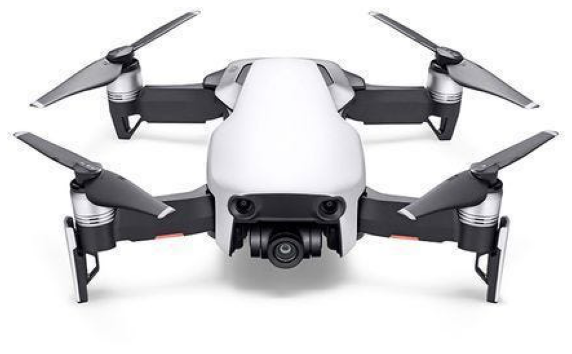

In [0]:
img_path = os.path.join(test_drone_dir, '00000037.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)